#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9584183812775327918
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11409156263897753416
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_kw.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(677, 16)
(677, 16)
(677, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   0%|          | 0/134 [00:00<?, ?it/s]

r_index: 100%|##########| 38/38 [00:00<00:00, 655.03it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(971, 16)
(887, 16)
(986, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(793, 15)
(719, 15)
(976, 15)


StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(634, 15)
(575, 15)
(780, 15)


#### 10-Fold Crossvalidation

In [23]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [24]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [25]:
from sklearn.model_selection import cross_val_score

def objectiveLGBM(trial: Trial, X_train, y_train) -> float:
    lgbm_paramas = {
        "random_state": 42,
        "learning_rate": 0.1, 
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "num_iterations": trial.suggest_int("num_iterations", 500, 1000)
    }
    
    lgbm = LGBMRegressor(**lgbm_paramas)
    r2 = cross_val_score(lgbm, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:03:20,342] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:03:22,358] Trial 0 finished with value: 0.5849266602779901 and parameters: {'n_estimators': 978, 'max_depth': 18, 'num_leaves': 19, 'min_child_samples': 4, 'num_iterations': 858}. Best is trial 0 with value: 0.5849266602779901.
[I 2023-08-24 14:03:24,414] Trial 1 finished with value: 0.5782702924566209 and parameters: {'n_estimators': 503, 'max_depth': 19, 'num_leaves': 25, 'min_child_samples': 5, 'num_iterations': 694}. Best is trial 0 with value: 0.5849266602779901.
[I 2023-08-24 14:03:25,716] Trial 2 finished with value: 0.5982296037069669 and parameters: {'n_estimators': 967, 'max_depth': 27, 'num_leaves': 12, 'min_child_samples': 6, 'num_iterations': 842}. Best is trial 2 with value: 0.5982296037069669.
[I 2023-08-24 14:03:26,567] Trial 3 finished with value: 0.5943771376403363 and parameters: {'n_estimators': 848, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 6, 'num_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:04:00,858] Trial 43 finished with value: 0.5748866959061555 and parameters: {'n_estimators': 943, 'max_depth': 24, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 525}. Best is trial 35 with value: 0.6145250952379463.
[I 2023-08-24 14:04:02,102] Trial 44 finished with value: 0.583156796952783 and parameters: {'n_estimators': 891, 'max_depth': 20, 'num_leaves': 16, 'min_child_samples': 2, 'num_iterations': 608}. Best is trial 35 with value: 0.6145250952379463.
[I 2023-08-24 14:04:02,667] Trial 45 finished with value: 0.6062069993295708 and parameters: {'n_estimators': 976, 'max_depth': 18, 'num_leaves': 9, 'min_child_samples': 8, 'num_iterations': 557}. Best is trial 35 with value: 0.6145250952379463.
[I 2023-08-24 14:04:03,665] Trial 46 finished with value: 0.6095696159884533 and parameters: {'n_estimators': 809, 'max_depth': 28, 'num_leaves': 13, 'min_child_samples': 9, 'num_iterations': 726}. Best is trial 35 with value: 0.6145250952379463.
[I 2023-08-24

Best r2:  0.6173206646497006
Best trial: {'n_estimators': 723, 'max_depth': 21, 'num_leaves': 10, 'min_child_samples': 8, 'num_iterations': 519}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 723, 'max_depth': 21, 'num_leaves': 10, 'min_child_samples': 8, 'num_iterations': 519}


In [29]:
study.best_trial.params["n_estimators"]

723

In [30]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=21, min_child_samples=8, n_estimators=723,
              num_iterations=519, num_leaves=10, random_state=42)

In [31]:
y_train_pred = lgbm.predict(As_X_train)
y_test_pred = lgbm.predict(As_X_test)

In [32]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [33]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.1000863503828073
Test RMSE:  0.86651648788271


In [34]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9879280791880671
Test R2:  0.08895378020702782


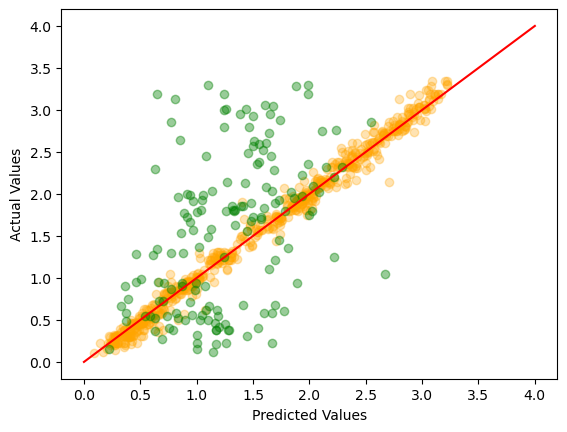

In [35]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [36]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:04:42,262] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:04:43,751] Trial 0 finished with value: 0.6787905670578132 and parameters: {'n_estimators': 863, 'max_depth': 26, 'num_leaves': 21, 'min_child_samples': 6, 'num_iterations': 656}. Best is trial 0 with value: 0.6787905670578132.
[I 2023-08-24 14:04:44,271] Trial 1 finished with value: 0.6336174391773497 and parameters: {'n_estimators': 762, 'max_depth': 8, 'num_leaves': 4, 'min_child_samples': 9, 'num_iterations': 904}. Best is trial 0 with value: 0.6787905670578132.
[I 2023-08-24 14:04:44,823] Trial 2 finished with value: 0.6512968051851356 and parameters: {'n_estimators': 521, 'max_depth': 11, 'num_leaves': 5, 'min_child_samples': 9, 'num_iterations': 766}. Best is trial 0 with value: 0.6787905670578132.
[I 2023-08-24 14:04:45,353] Trial 3 finished with value: 0.6508561326885374 and parameters: {'n_estimators': 538, 'max_depth': 14, 'num_leaves': 7, 'min_child_samples': 10, 'num_it

Best r2:  0.6865425005479568
Best trial: {'n_estimators': 680, 'max_depth': 23, 'num_leaves': 22, 'min_child_samples': 2, 'num_iterations': 671}


In [37]:
optuna.visualization.plot_parallel_coordinate(study)

In [38]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 680, 'max_depth': 23, 'num_leaves': 22, 'min_child_samples': 2, 'num_iterations': 671}


680

In [39]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=23, min_child_samples=2, n_estimators=680,
              num_iterations=671, num_leaves=22, random_state=42)

In [40]:
y_train_pred = lgbm.predict(Cd_X_train)
y_test_pred = lgbm.predict(Cd_X_test)

In [41]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.01744880871759543
Test RMSE:  0.2632671989804146


In [42]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9973612743595583
Test R2:  0.36407450549991505


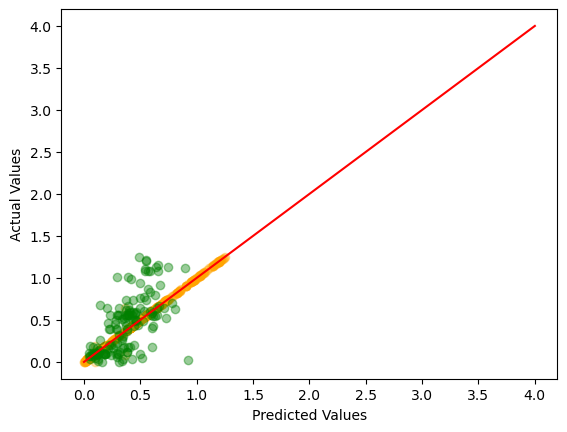

In [43]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4], [0, 4], color='red', linestyle='-')

plt.show()

Ni

In [44]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:07:53,645] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:07:54,264] Trial 0 finished with value: 0.6714357775292569 and parameters: {'n_estimators': 951, 'max_depth': 2, 'num_leaves': 18, 'min_child_samples': 3, 'num_iterations': 648}. Best is trial 0 with value: 0.6714357775292569.
[I 2023-08-24 14:07:55,130] Trial 1 finished with value: 0.7181967342855865 and parameters: {'n_estimators': 978, 'max_depth': 12, 'num_leaves': 5, 'min_child_samples': 10, 'num_iterations': 672}. Best is trial 1 with value: 0.7181967342855865.
[I 2023-08-24 14:07:59,212] Trial 2 finished with value: 0.717361205617169 and parameters: {'n_estimators': 649, 'max_depth': 15, 'num_leaves': 27, 'min_child_samples': 10, 'num_iterations': 656}. Best is trial 1 with value: 0.7181967342855865.
[I 2023-08-24 14:07:59,978] Trial 3 finished with value: 0.6933545177944771 and parameters: {'n_estimators': 703, 'max_depth': 2, 'num_leaves': 19, 'min_child_samples': 8, 'num_i

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:08:39,247] Trial 20 finished with value: 0.7320994136614308 and parameters: {'n_estimators': 941, 'max_depth': 7, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 833}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:40,489] Trial 21 finished with value: 0.7283655270665326 and parameters: {'n_estimators': 937, 'max_depth': 7, 'num_leaves': 6, 'min_child_samples': 9, 'num_iterations': 836}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:43,263] Trial 22 finished with value: 0.7251618737610623 and parameters: {'n_estimators': 959, 'max_depth': 6, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 797}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:45,323] Trial 23 finished with value: 0.7343457173530796 and parameters: {'n_estimators': 793, 'max_depth': 5, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 737}. Best is trial 7 with value: 0.7348771098400781.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:08:47,566] Trial 24 finished with value: 0.7279017995624077 and parameters: {'n_estimators': 784, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 7, 'num_iterations': 727}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:52,453] Trial 25 finished with value: 0.7108469219299298 and parameters: {'n_estimators': 867, 'max_depth': 13, 'num_leaves': 29, 'min_child_samples': 10, 'num_iterations': 762}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:56,218] Trial 26 finished with value: 0.7112512543445944 and parameters: {'n_estimators': 796, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 7, 'num_iterations': 704}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:08:57,934] Trial 27 finished with value: 0.7331670552309916 and parameters: {'n_estimators': 733, 'max_depth': 4, 'num_leaves': 30, 'min_child_samples': 9, 'num_iterations': 820}. Best is trial 7 with value: 0.7348771098400781.
[I 2023-08-24 14:

Best r2:  0.7393472990728669
Best trial: {'n_estimators': 920, 'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 8, 'num_iterations': 854}


In [45]:
optuna.visualization.plot_parallel_coordinate(study)

In [46]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 920, 'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 8, 'num_iterations': 854}


920

In [47]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Ni_X_train, Ni_y_train)

LGBMRegressor(max_depth=4, min_child_samples=8, n_estimators=920,
              num_iterations=854, num_leaves=27, random_state=42)

In [48]:
y_train_pred = lgbm.predict(Ni_X_train)
y_test_pred = lgbm.predict(Ni_X_test)

In [49]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.060822308311871166
Test RMSE:  0.9610217100962682


In [50]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9973165566343807
Test R2:  0.45545386481607175


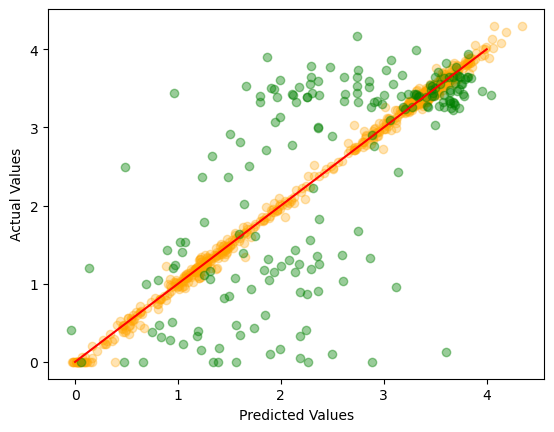

In [51]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()